# Processing combined segments

## Gathering basic datasets

We'll set ourselves up with a basic function to read and optionally save a dataframe

In [53]:
import hashlib

import geopandas as gpd
import pandas as pd

from shapely.wkt import dumps

def read_open_dataframe(path, file_name=None):
    df = gpd.read_file(path)
    if file_name is not None:
        df.to_file(file_name, driver='GeoJSON')
    return df

We'll read in the street segments

In [54]:
streets = read_open_dataframe(
  'https://opendata.arcgis.com/datasets/ad5ed4193110452aac2d9485df3298e2_68.geojson'
)

In [55]:
streets['hash'] = streets.geometry.map(dumps).map(lambda x: hashlib.sha256(str(x).encode('utf-8')).hexdigest())
streets.head()

,OBJECTID,LENGTH,LOCALID,ZERO,PREFIX,STREETNAME,FTYPE,DIRECTION,LEFTADD1,LEFTADD2,...,BTM_SEG_ID,PDX_F_NODE,PDX_T_NODE,UPD_DATE,CREATE_DAT,F_ZLEV,T_ZLEV,Shape_Length,geometry,hash
0,1,317.850680,191120,0,SE,89TH,AVE,1,7910,8078,...,None,100413.0,72841.0,2014-09-29T20:07:16,1998-07-20T17:30:29,1.0,1.0,138.371584,LINESTRING (-122.5719175992177 45.465833076113...,92e9bd3c75ed5d40c2b72f4aa948ab706b70e5d18077e9...
1,2,260.533287,191146,0,NW,BROADWAY,,1,0,0,...,None,48689.0,100431.0,2014-09-29T20:07:18,1998-08-24T23:51:47,1.0,1.0,113.542776,LINESTRING (-122.6776090268029 45.527326932427...,fb1b3d5f44c1864e61d708a8ba71dd0c7308b030749bbb...
2,3,262.867974,191152,0,NE,116TH,AVE,1,4501,4549,...,None,39638.0,100437.0,2014-09-29T20:07:19,1998-09-14T21:42:05,1.0,1.0,114.616555,LINESTRING (-122.5432407486747 45.555387465021...,d844cc5d894ababb289c3fc9e7e0f729cfca49606a9ecf...
3,4,592.787534,191303,0,SW,VESTA,ST,1,3500,3698,...,None,77655.0,77643.0,2014-09-29T20:07:28,1998-12-21T22:58:24,1.0,1.0,257.098922,LINESTRING (-122.7128168127177 45.441128071564...,3443b98bd5c8c8dfc1d4512e9f49481bdf9902889705ad...
4,5,152.178986,218661,0,SW,66TH,AVE,1,11100,11198,...,None,76212.0,76294.0,2014-09-29T20:07:59,None,1.0,1.0,66.195537,LINESTRING (-122.7447389071747 45.447373164757...,ff082321df1f7a0f196d65f74c2b5a2f3404007b5f4554...


In [56]:
street_segment_type_map = {
  '1110': 'Freeway',
  '1120': 'Ramps, Interchanges(one Freeway to another)',
  '1121':
    'On - Ramp or Slip Road Linkage(used to enter a Freeway or lower class road)',
  '1122':
    'Off - Ramp or Slip Road Linkage(used to exit a Freeway or lower class road)',
  '1123':
    'On / Off - Ramp or Slip Road Linkage(used to enter or exit a Freeway or lower class road)',
  '1200': 'Highway',
  '1221':
    'On - Ramp or Slip Road Linkage(used to enter a Highway or lower class road)',
  '1222':
    'Off - Ramp or Slip Road Linkage(used to exit a Highway or lower class road)',
  '1223':
    'On / Off - Ramp or Slip Road Linkage(used to enter or exit a Highway or lower class road)',
  '1300': 'Primary Arterial',
  '1321':
    'Primary Arterial Linkage(ramp/ slip road used to enter or exit a Primary Arterial or loser class road)',
  '1400': 'Arterial',
  '1421':
    'Arterial Linkage(ramp / slip road used to enter or exit an Arterial or lower class road)',
  '1450': 'Tertiary Street - Neighborhood Collector',
  '1471':
    'Tertiary Street Linkage(ramp / slip road used to enter a Tertiary Street or lower class road)',
  '1500': 'Minor Residential',
  '1521': 'Ramp / Slip Road used to enter or exit a Residential Street',
  '1550':
    "Minor Residential Street(Unclassified), named but without addresses(Clackamas Co.only, SUBAREA = 'C')",
  '1560':
    "Minor Residential Street(Unclassified), unnamed and without addresses(Clackamas Co.only, SUBAREA = 'C')",
  '1600': 'Alley',
  '1700': 'Private Named Road',
  '1780': 'Private Street, (planned)',
  '1800': 'Unnamed Private Road / Driveway',
  '1900': 'Pulic ROW EXISTS but no built roadway exists',
  '1950': 'Public planned street with addresses(will be active soon)',
  '1970': 'Virtual Segment; not a real roadway(accommodates address anomalies)',
  '1980':
    'Paper Street with addresses(accommodates address anomalies - in ROW unlike 1970)',
  '1990': 'Vacated Street',
  '2100': 'Railroad',
  '2200': 'Rapid Transit(MAX)',
  '3100': 'Non - Specific or Shared - Use Path',
  '3230': 'Steps(most have addresses)',
  '5101':
    'Freeway with Rapid Transit(MAX or streetcar).Auto traffic and rail trackage in shared ROW.',
  '5201':
    'Highway with Rapid Transit(MAX or streetcar).Auto traffic and rail trackage in shared ROW.',
  '5301':
    'Primary Arterial with Rapid Transit(MAX or streetcar).Auto traffic and rail trackage in shared ROW.',
  '5401':
    'Arterial with Rapid Transit(MAX or streetcar).Auto traffic and rail trackage in shared ROW.',
  '5402':
    'Secondary arterial with rapid transit, but no regular vehicle traffic.',
  '5450':
    'Tertiary Street with Railroad.Auto traffic and rail trackage in shared ROW.',
  '5451':
    'Tertiary Street with Rapid Transit(MAX or streetcar).Auto traffic and rail trackage in shared ROW.',
  '5500':
    'Minor Residential with Railroad.Auto traffic and rail trackage in shared ROW.',
  '5501':
    'Minor Residential with Rapid Transit(MAX or streetcar).Auto traffic and rail trackage in shared ROW.',
  '7700':
    'Short segments indicating mile post locations along certain highways to assist emergency dispatch in Clackamas and Washington Counties.These are short pseudo - segments that do not exist(Clackamas and Washington Counties only).',
  '8224': "Unknown Type(only in Yamhill County, SUBAREA = 'Y')",
  '9000': 'Forest Service Road'
};

In [57]:
street_segment_type_map = pd.DataFrame.from_dict(street_segment_type_map, orient='index', columns=['type'])
street_segment_type_map.index = street_segment_type_map.index.astype('int64')
street_segment_type_map.head()

,type
1110,Freeway
1120,"Ramps, Interchanges(one Freeway to another)"
1121,On - Ramp or Slip Road Linkage(used to enter a...
1122,Off - Ramp or Slip Road Linkage(used to exit a...
1123,On / Off - Ramp or Slip Road Linkage(used to e...


In [58]:
streets = streets.join(street_segment_type_map, on='TYPE')
streets.head()

,OBJECTID,LENGTH,LOCALID,ZERO,PREFIX,STREETNAME,FTYPE,DIRECTION,LEFTADD1,LEFTADD2,...,PDX_F_NODE,PDX_T_NODE,UPD_DATE,CREATE_DAT,F_ZLEV,T_ZLEV,Shape_Length,geometry,hash,type
0,1,317.850680,191120,0,SE,89TH,AVE,1,7910,8078,...,100413.0,72841.0,2014-09-29T20:07:16,1998-07-20T17:30:29,1.0,1.0,138.371584,LINESTRING (-122.5719175992177 45.465833076113...,92e9bd3c75ed5d40c2b72f4aa948ab706b70e5d18077e9...,Minor Residential
1,2,260.533287,191146,0,NW,BROADWAY,,1,0,0,...,48689.0,100431.0,2014-09-29T20:07:18,1998-08-24T23:51:47,1.0,1.0,113.542776,LINESTRING (-122.6776090268029 45.527326932427...,fb1b3d5f44c1864e61d708a8ba71dd0c7308b030749bbb...,Arterial
2,3,262.867974,191152,0,NE,116TH,AVE,1,4501,4549,...,39638.0,100437.0,2014-09-29T20:07:19,1998-09-14T21:42:05,1.0,1.0,114.616555,LINESTRING (-122.5432407486747 45.555387465021...,d844cc5d894ababb289c3fc9e7e0f729cfca49606a9ecf...,Minor Residential
3,4,592.787534,191303,0,SW,VESTA,ST,1,3500,3698,...,77655.0,77643.0,2014-09-29T20:07:28,1998-12-21T22:58:24,1.0,1.0,257.098922,LINESTRING (-122.7128168127177 45.441128071564...,3443b98bd5c8c8dfc1d4512e9f49481bdf9902889705ad...,Minor Residential
4,5,152.178986,218661,0,SW,66TH,AVE,1,11100,11198,...,76212.0,76294.0,2014-09-29T20:07:59,None,1.0,1.0,66.195537,LINESTRING (-122.7447389071747 45.447373164757...,ff082321df1f7a0f196d65f74c2b5a2f3404007b5f4554...,Minor Residential


Then, we'll read in the bicycle network

In [59]:
# Can't save the bike network yet since some geometry is malformed
bike_network = read_open_dataframe(
    'https://opendata.arcgis.com/datasets/dbd6b5aa0ab14c859874eb41000e6a56_75.geojson'
)

In [60]:
bike_network['hash'] = bike_network.geometry.map(dumps).map(lambda x: hashlib.sha256(str(x).encode('utf-8')).hexdigest())
bike_network.head()

,OBJECTID,TranPlanID,SegmentName,Status,Facility,YearBuilt,Shape_Length,YearRetired,SCS,LengthMiles,geometry,hash
0,1,TP06-0000001,SW 65TH AVE,RECOMM,NG,NaN,192.430464,NaN,None,0.084,LINESTRING (-122.7436774740046 45.487094641506...,3850f192369225f337cf8163fe7c7f651bf8dbbc6ef7db...
1,2,TP06-0000002,SW BOUNDARY ST,RECOMM,NG,NaN,231.862884,NaN,None,0.101,LINESTRING (-122.7416830865131 45.485864753641...,59419846d8f27a1d80d9a552cace11088cbfc17439741c...
2,3,TP06-0000003,SW BOUNDARY ST,RECOMM,NG,NaN,73.621507,NaN,None,0.032,LINESTRING (-122.7410217674622 45.485860038361...,88796815b395d664ae0683702722876e321f59497a6b0c...
3,4,TP06-0000004,SW PENDLETON ST,RECOMM,ESR,NaN,336.626010,NaN,None,0.147,LINESTRING (-122.716760171575 45.4806457154275...,aff82f3db1b668e3fa239196babd7b5dd6185671517b15...
4,5,TP06-0000005,SW SUNSET BLVD,ACTIVE,BL,2014.0,146.757123,NaN,None,0.064,LINESTRING (-122.6955563403036 45.480977750122...,e440daaedf22de22080631e85e918ebb5bb3c36b1b5f35...


We'll filter down the bike_network to only those that we are interested in: Active trails

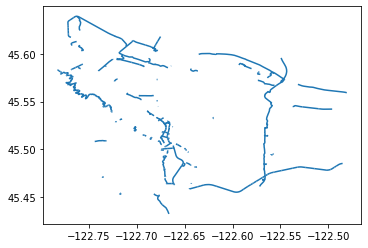

In [61]:
bike_network = bike_network[bike_network['Status'] == 'ACTIVE']
bike_network = bike_network[bike_network['Facility'] == 'TRL']
bike_network.plot()

We will trim these down to just the midpoint of the line geometry

In [62]:
streets['repr_point'] = streets.interpolate(0.5, normalized=True)
bike_network['repr_point'] = bike_network.interpolate(0.5, normalized=True)

Let's clean up the columns a bit...

In [63]:
streets = streets[['FULL_NAME','hash', 'TYPE', 'type', 'geometry', 'repr_point', 'OBJECTID']]
streets = streets.rename(index=str, columns={"FULL_NAME": "name", 'type': 'type_name', 'TYPE': 'type_key'})
streets.head()

,name,hash,type_key,type_name,geometry,repr_point,OBJECTID
0,SE 89TH AVE,92e9bd3c75ed5d40c2b72f4aa948ab706b70e5d18077e9...,1500,Minor Residential,LINESTRING (-122.5719175992177 45.465833076113...,POINT (-122.5719134494502 45.46539719849665),1
1,NW BROADWAY,fb1b3d5f44c1864e61d708a8ba71dd0c7308b030749bbb...,1400,Arterial,LINESTRING (-122.6776090268029 45.527326932427...,POINT (-122.6776160529759 45.52768417667291),2
2,NE 116TH AVE,d844cc5d894ababb289c3fc9e7e0f729cfca49606a9ecf...,1500,Minor Residential,LINESTRING (-122.5432407486747 45.555387465021...,POINT (-122.5432390077397 45.55574793993071),3
3,SW VESTA ST,3443b98bd5c8c8dfc1d4512e9f49481bdf9902889705ad...,1500,Minor Residential,LINESTRING (-122.7128168127177 45.441128071564...,POINT (-122.7139715875832 45.44112578737376),4
4,SW 66TH AVE,ff082321df1f7a0f196d65f74c2b5a2f3404007b5f4554...,1500,Minor Residential,LINESTRING (-122.7447389071747 45.447373164757...,POINT (-122.7448480416593 45.44721698630497),5


In [64]:
bike_network = bike_network[['SegmentName','hash', 'Facility', 'geometry', 'repr_point', 'OBJECTID']]
bike_network = bike_network.rename(index=str, columns={"SegmentName": "name", 'Facility': 'type_key'})
bike_network.head()

,name,hash,type_key,geometry,repr_point,OBJECTID
34,N LOMBARD ST,ad70ba2427d83cae8686d8562173aedd86140b3ce28f17...,TRL,LINESTRING (-122.7716525983769 45.627260094240...,POINT (-122.7717031461288 45.62852104326291),35
35,N LOMBARD ST,5a16cb332bf67b5913ece23e642ba65de23f69306fb23f...,TRL,LINESTRING (-122.7713743757604 45.620318504417...,POINT (-122.7713854726491 45.62056059191839),36
178,NW LEIF ERIKSON DR,49fff9294e28f971f92cd79cd97c0050865883a769d1f4...,TRL,LINESTRING (-122.7266026860546 45.540707787663...,POINT (-122.7268688970905 45.54146992306962),179
210,SW PEDESTRIAN TRL,a8f6e76384856018075bcbb346e9a834a64fa1afd8baab...,TRL,LINESTRING (-122.6845810960647 45.512283743131...,POINT (-122.68476598013 45.51194980927482),211
218,SW LEWIS AND CLARK CIR,309acef638316c0c5cfca906ea50d767dba93162cb907e...,TRL,LINESTRING (-122.7007347371493 45.521037252985...,POINT (-122.7007260908647 45.52117350218415),219


In [65]:
result = pd.concat([streets, bike_network])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [66]:
len(result)

108436

In [67]:
result.groupby('name').count().describe()

,OBJECTID,geometry,hash,repr_point,type_key,type_name
count,20044.000000,20044.000000,20044.000000,20044.000000,20044.000000,20044.000000
mean,5.409649,5.409649,5.409649,5.409649,5.409649,5.393285
std,31.452622,31.452622,31.452622,31.452622,31.452622,31.424603
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3940.000000


In [68]:
result['repr_x'] = result.repr_point.map(lambda g: g.x)
result['repr_y'] = result.repr_point.map(lambda g: g.y)
del result['repr_point']

In [69]:
result = result.reset_index()
del result['index']
result

,OBJECTID,geometry,hash,name,type_key,type_name,repr_x,repr_y
0,1,LINESTRING (-122.5719175992177 45.465833076113...,92e9bd3c75ed5d40c2b72f4aa948ab706b70e5d18077e9...,SE 89TH AVE,1500,Minor Residential,-122.571913,45.465397
1,2,LINESTRING (-122.6776090268029 45.527326932427...,fb1b3d5f44c1864e61d708a8ba71dd0c7308b030749bbb...,NW BROADWAY,1400,Arterial,-122.677616,45.527684
2,3,LINESTRING (-122.5432407486747 45.555387465021...,d844cc5d894ababb289c3fc9e7e0f729cfca49606a9ecf...,NE 116TH AVE,1500,Minor Residential,-122.543239,45.555748
3,4,LINESTRING (-122.7128168127177 45.441128071564...,3443b98bd5c8c8dfc1d4512e9f49481bdf9902889705ad...,SW VESTA ST,1500,Minor Residential,-122.713972,45.441126
4,5,LINESTRING (-122.7447389071747 45.447373164757...,ff082321df1f7a0f196d65f74c2b5a2f3404007b5f4554...,SW 66TH AVE,1500,Minor Residential,-122.744848,45.447217
5,6,LINESTRING (-122.8043218324354 45.614237556015...,821f884bcb94f98f72c9d4a6f70151cf59c967da06d33e...,NW CRESTON RD,1500,Minor Residential,-122.804426,45.614303
6,7,LINESTRING (-122.8040989577185 45.614095487060...,23696fb7f70316f43ab17c56e911bb9f4d283faa683071...,NW CRESTON RD,1500,Minor Residential,-122.804210,45.614167
7,8,LINESTRING (-122.7894148858785 45.603585480815...,929e54c1cbfa3878cbf71f32cfc8f81ad868d62792301f...,NW ST HELENS RD,1200,Highway,-122.789567,45.603784
8,9,LINESTRING (-122.6088085521922 45.553917069437...,99cd67da013b6e8b328b854bc451056aa39675fc51ebea...,NE SKIDMORE ST,1500,Minor Residential,-122.608157,45.553914
9,10,LINESTRING (-122.5210257548548 45.484303134390...,01f597b36e894f36676bb071cc9d29c42f736a9e2370b0...,SE STEELE ST,1500,Minor Residential,-122.520426,45.484307


In [70]:
result.to_file('../.data/combined_filtered_segments.geojson', driver='GeoJSON')

## Creating voronoi cells for segments

In [71]:
result = gpd.read_file('../.data/combined_filtered_segment_midpoints.geojson')
voronoi = gpd.read_file('../.data/combined_filtered_segment_voronoi.geojson')

In [72]:
combined = gpd.sjoin(voronoi, result, how='inner', op='intersects')[['geometry', 'name', 'type','repr_x', 'repr_y']]
combined.head()

,geometry,name,type,repr_x,repr_y
0,POLYGON ((-122.5748132076994 45.54110166950601...,NE RUSSELL ST,Minor Residential,-122.574239,45.540883
1,POLYGON ((-122.6503378612164 45.59861661774314...,NE 13TH AVE,Minor Residential,-122.651975,45.597715
2,POLYGON ((-122.5773157713236 45.54293976632954...,NE 84TH AVE,Minor Residential,-122.576348,45.541691
3,POLYGON ((-122.5727560154893 45.46582692286658...,SE 89TH AVE,Minor Residential,-122.571913,45.465397
4,POLYGON ((-122.6781024337198 45.52767332236773...,NW BROADWAY,Arterial,-122.677616,45.527684


In [ ]:
combined.to_file('../.data/segment_cells.geojson', driver='GeoJSON')

In [ ]:
from shapely.wkt import dumps
combined['wkt'] = combined.geometry.map(lambda x: dumps(x))
combined.head()